In [1]:
import sys
import os
import pandas as pd
import scanpy as sc
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import spatialdm as sdm
import seaborn as sns

In [2]:
from copulacci import spatial
from copulacci import model2
from copulacci import model

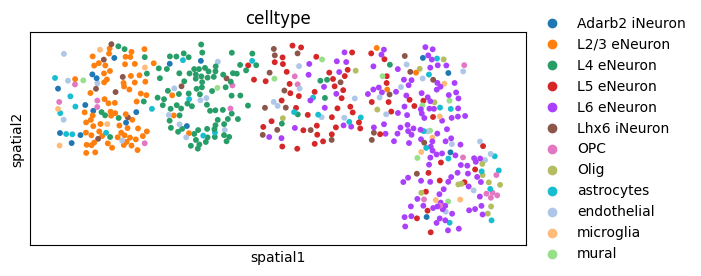

In [3]:
sp_datadir = './data/original_data'
X = sparse.load_npz(sp_datadir+'/expression.npz')
genes = list( np.loadtxt(sp_datadir+'/genes.txt', dtype=str) )
pts = np.loadtxt( sp_datadir+'/positions.csv' )
adata_sp = sc.AnnData(X=X, var=pd.DataFrame(index=genes))
adata_sp.obsm['spatial'] = pts
df_celltype = pd.read_csv('./data/celltype_annotation.csv', index_col=0)
celltypes = list(df_celltype.values.reshape(-1))
adata_sp.obs['celltype'] = pd.Series(list(celltypes), dtype="category").values
sc.pl.spatial(adata_sp, color='celltype', spot_size=100)

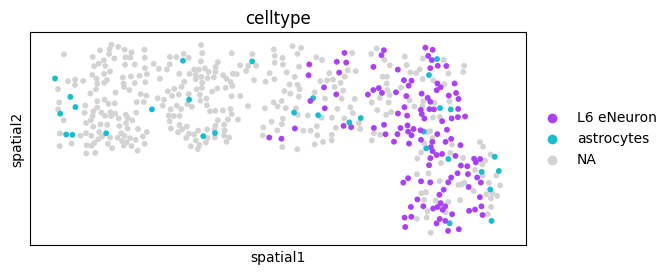

In [88]:
sc.pl.spatial(adata_sp,   
              color = ['celltype'], groups = ['astrocytes', 'L6 eNeuron'],
              spot_size=100)

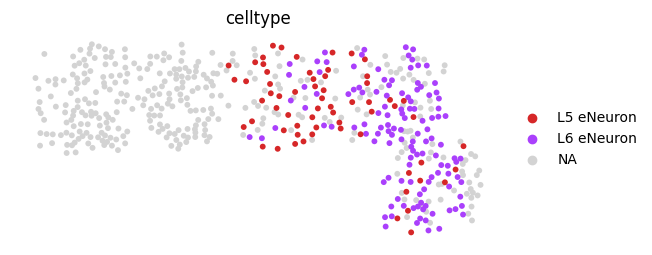

In [94]:
sc.pl.spatial(adata_sp,   
              color = ['celltype'], groups = ['L5 eNeuron', 'L6 eNeuron'],
              frameon = False,
              spot_size=100,save='seqfish_two_celltypes.pdf')

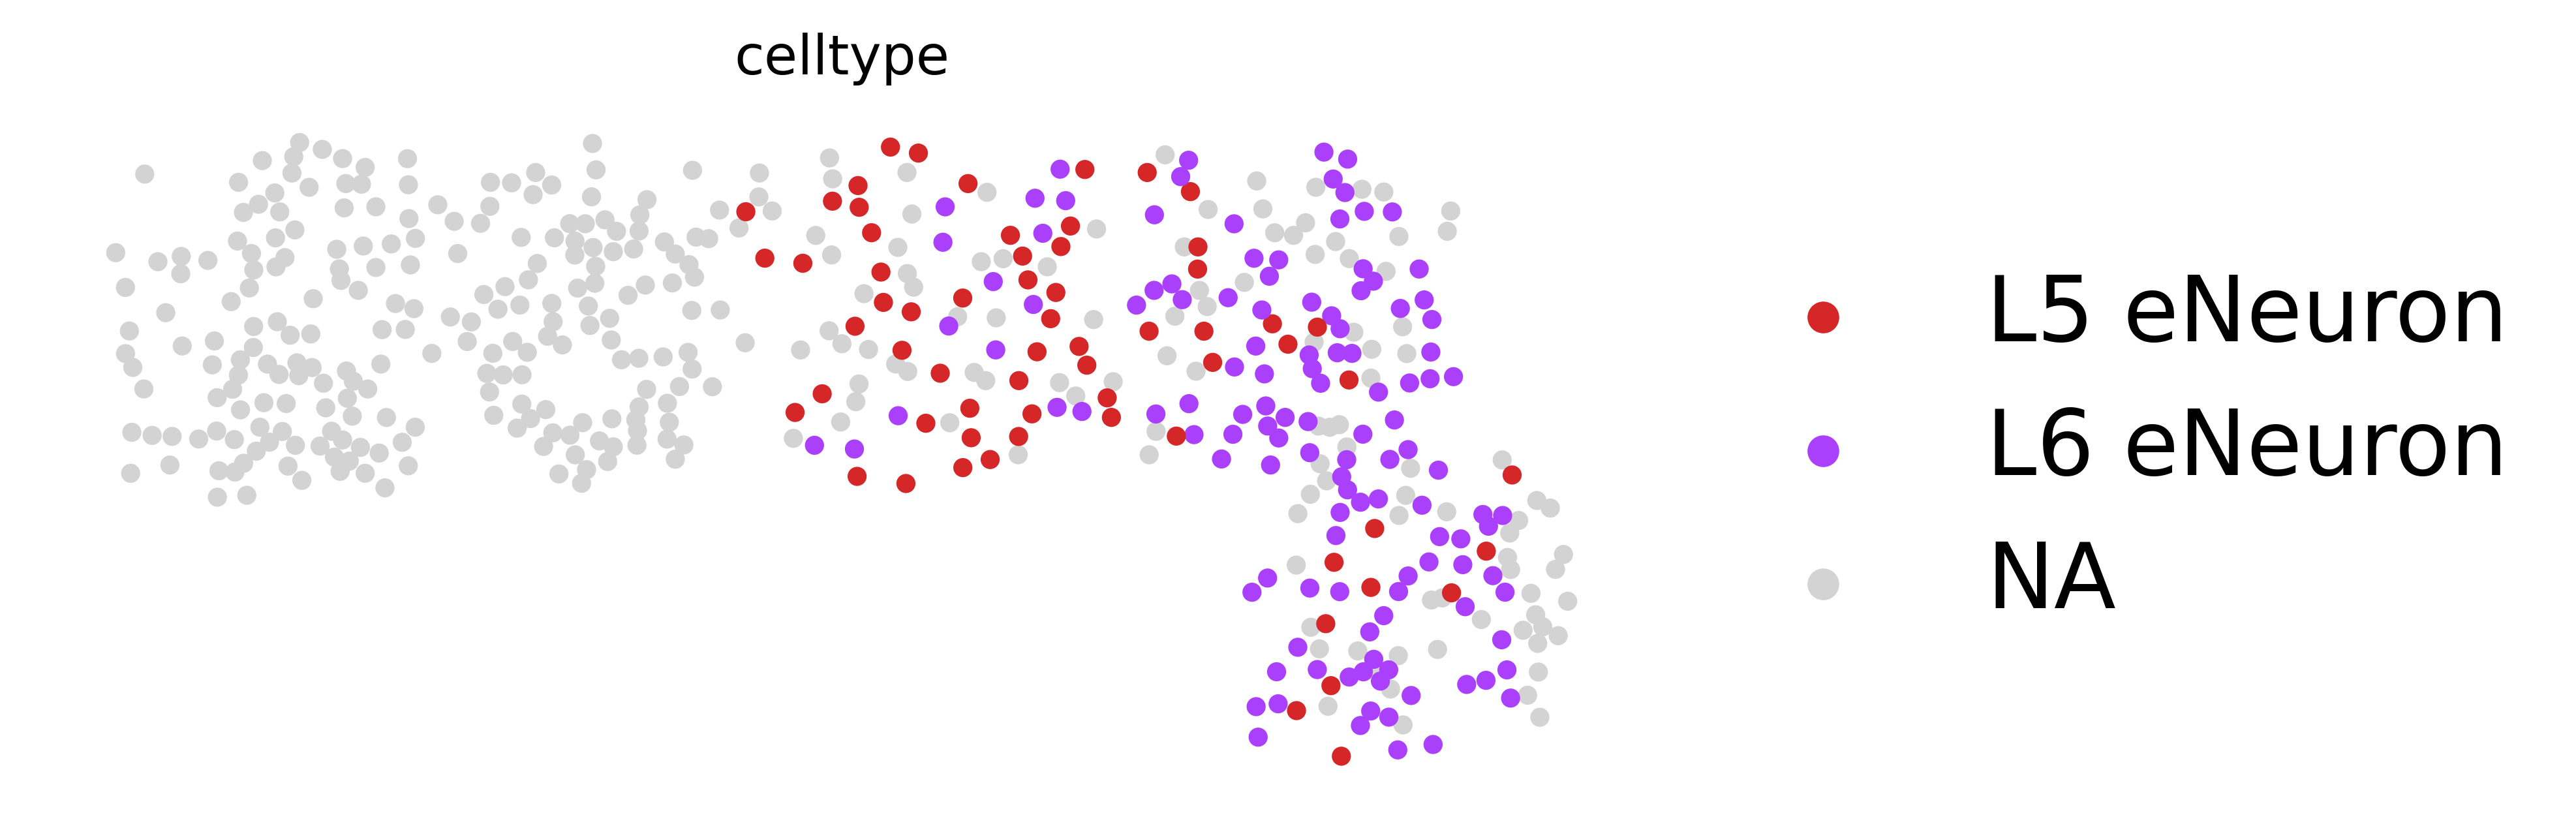

In [96]:
figure_parent = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
with plt.rc_context(rc={'figure.dpi': 500}):  # Use this to set figure params like size and dpi
    sc.pl.spatial(adata_sp,   
        color = ['celltype'], groups = ['L5 eNeuron', 'L6 eNeuron'],
              frameon = False,
              spot_size=100,
            legend_fontsize=20,
            show=False
    )
    plt.savefig(os.path.join(figure_parent, 'seqfish_two_celltypes.pdf'), bbox_inches="tight")

In [4]:
parent_dir = './'
prefix = 'seqfish_sdm'
print('Filter ligand receptor pairs using SpatialDM filter', flush=True)
ligand_df = pd.read_csv(os.path.join(parent_dir, prefix + '_ligand.csv'),index_col=0)
receptor_df = pd.read_csv(os.path.join(parent_dir, prefix + '_receptor.csv'), index_col=0)
geneinter_df = pd.read_csv(os.path.join(parent_dir, prefix + '_geneInter.csv'), index_col=0)
ligand_df = ligand_df.where(pd.notna(ligand_df), None)
receptor_df = receptor_df.where(pd.notna(receptor_df), None)
geneinter_df = geneinter_df.where(pd.notna(geneinter_df), None)

Filter ligand receptor pairs using SpatialDM filter


In [51]:
lig_rec_info_df=geneinter_df.copy()
close_contact_index = []
other_index = []
for index,row in lig_rec_info_df.iterrows():
    if row.annotation == 'Cell-Cell Contact':
        close_contact_index += [index]
    else:
        other_index += [index]

In [6]:
spatial_params = spatial.SpatialParams()
spatial_params = spatial_params._replace(data_type='other',radius=250, coord_type='generic')
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata_sp,
    force_recalculate=True,
    distance_aware=True,
    spatial_params=spatial_params
)

Constructing spatial network with other


100%|██████████████████████████████████████████████████████████████████| 523/523 [00:00<00:00, 33210.52it/s]


In [7]:
focus_interactions = int_edges_new.interaction.value_counts()[
int_edges_new.interaction.value_counts() > 50
].index

In [11]:
adata_sp.raw = adata_sp.copy()
count_df = adata_sp.raw.to_adata().to_df()

In [67]:
allow_same_lr = True
lig_rec_list = []
for i in range(ligand_df.shape[0]):
    ligands =  ligand_df.iloc[i].values
    receptors = receptor_df.iloc[i].values
    ligands = set([l for l in ligands if l is not None])
    receptors  = set([l for l in receptors if l is not None])
    # Make a datafram with two columns
    for l in ligands:
        for r in receptors:
            if not allow_same_lr:
                if l != r:
                    lig_rec_list.append([l, r])
            else:
                lig_rec_list.append([l, r])

df_lig_rec = pd.DataFrame(lig_rec_list, columns = ['ligand', 'receptor'])
df_lig_rec = df_lig_rec.drop_duplicates()
df_lig_rec.index = list(range(df_lig_rec.shape[0]))
chosen_lr = list(set( df_lig_rec.ligand.unique()).union(
    set( df_lig_rec.receptor.unique() )
))

In [70]:
geneinter_df.shape

(1157, 9)

In [71]:
count_df.shape

(523, 10000)

In [74]:
count_lr = count_df.loc[:,chosen_lr]

In [84]:
(count_lr>0).sum().mean()/523

0.30769498884639895

In [83]:
np.nonzero(count_lr)[0].shape[0] / np.prod(np.shape(count_lr))

0.30769498884639895

In [13]:
data_list_dict, umi_sums, data_list_dict_close, umi_sums_close = \
spatial.prepare_data_list_for_other(
    count_df,
    int_edges_new,
    groups = list(focus_interactions),
    lig_rec_info_df=geneinter_df,
    heteromeric=True,
    lig_df=ligand_df,
    rec_df=receptor_df,
    summarization='sum',
    separate_lig_rec_type=True,
    close_contact_threshold=50
)

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


In [14]:
def add_pvalue(row, bg_permutation_dict):
    if row.name in bg_permutation_dict:
        bg = bg_permutation_dict[row.name]
        if len(bg) < 100:
            return 1.0
        I = row.copula_coeff
        bg = np.append(bg, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        return pval
    return 1.0

In [15]:
import pickle
with open('copula_estimates.pkl', 'rb') as fp:
    copulacci_spatial_res = pickle.load(fp)
with open('copula_permutation.pkl', 'rb') as fp:
    copulacci_spatial_perm = pickle.load(fp)

In [17]:
from statsmodels.stats.multitest import multipletests
for ct in copulacci_spatial_res:
    copula_df = copulacci_spatial_res[ct].copy()
    copula_df['copula_pval'] = copula_df.apply(lambda row: add_pvalue(row,copulacci_spatial_perm[ct]), axis=1)
    # if ct in copulacci_spatial_res_close:
    #     copula_df_close = copulacci_spatial_res_close[ct].copy()
    #     if ct in copulacci_spatial_perm_close:
    #         copula_df_close['copula_pval'] = copula_df_close.apply(lambda row: add_pvalue(row,copulacci_spatial_perm_close[ct]), axis=1)
    #     else:
    #         copula_df_close['copula_pval'] = 1.0
    #     copula_df = pd.concat([copula_df, copula_df_close])
    
    reject, pvals_corrected, _, _ = multipletests(
        copula_df.copula_pval, 
        alpha=0.05, 
        method='fdr_bh')
    copula_df['copula_pval_fdr'] = pvals_corrected
    copulacci_spatial_res[ct] = copula_df.copy()

In [18]:
copulacci_spatial_res.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [20]:
adata_scc = adata_sp.copy()

In [21]:
scc_df_dict = model2.run_scc(
    adata_scc,
    geneinter_df,
    int_edges_new,
    groups=list(copulacci_spatial_res.keys()),
    lig_df=ligand_df,
    rec_df=receptor_df,
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

L5 eNeuron=L6 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   10.9s
[Parallel(n_jobs=20)]: Done 640 tasks      | elapsed:   14.0s
[Parallel(n_jobs=20)]: Done 979 out of 1018 | elapsed:   15.9s remaining:    0.6s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:   16.0s finished


L6 eNeuron=L5 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    6.3s finished


L2/3 eNeuron=L4 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 979 out of 1018 | elapsed:    3.6s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    3.7s finished


L4 eNeuron=L2/3 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    3.7s finished


astrocytes=L6 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    3.6s finished


L6 eNeuron=astrocytes


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    3.9s finished


In [22]:
with open('scc_estimates.pickle', 'wb') as fp:
    pickle.dump(scc_df_dict, fp)

In [23]:
adata_sdm = adata_sp.copy()
sc.pp.normalize_total(adata_sdm, target_sum=None)
sc.pp.log1p(adata_sdm)

In [24]:
sdm_df_dict = model.run_sdm(
    adata_sdm,
    int_edges_new,
    species='mouse',
    groups = list(copulacci_spatial_res.keys()),
    nproc = 20,
    heteronomic=True
)

L5 eNeuron=L6 eNeuron
DiGraph with 112 nodes and 117 edges
(112, 10000)
time taken for  L5 eNeuron=L6 eNeuron  is  14.186520099639893  seconds
L6 eNeuron=L5 eNeuron
DiGraph with 112 nodes and 117 edges
(112, 10000)
time taken for  L6 eNeuron=L5 eNeuron  is  13.454409837722778  seconds
L2/3 eNeuron=L4 eNeuron
DiGraph with 63 nodes and 67 edges
(63, 10000)
time taken for  L2/3 eNeuron=L4 eNeuron  is  10.57557201385498  seconds
L4 eNeuron=L2/3 eNeuron
DiGraph with 63 nodes and 67 edges
(63, 10000)
time taken for  L4 eNeuron=L2/3 eNeuron  is  10.075210094451904  seconds
astrocytes=L6 eNeuron
DiGraph with 62 nodes and 54 edges
(62, 10000)
time taken for  astrocytes=L6 eNeuron  is  10.811001062393188  seconds
L6 eNeuron=astrocytes
DiGraph with 62 nodes and 54 edges
(62, 10000)
time taken for  L6 eNeuron=astrocytes  is  10.47674298286438  seconds


In [25]:
with open('spatialsdm_estimates.pickle', 'wb') as fp:
    pickle.dump(sdm_df_dict, fp)

In [26]:
merged_res_dict = {}
for gpair in list(copulacci_spatial_res.keys()):
    if (
        (gpair in scc_df_dict) and 
        (gpair in sdm_df_dict) 
    ):
        tmp1 = scc_df_dict[gpair].copy()
        tmp2 = sdm_df_dict[gpair].copy()
        tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')
        res = copulacci_spatial_res[gpair]
        res = res.loc[res.copula_method == 'copula']
        res = copulacci_spatial_res[gpair].join(tmp3, how='inner')
        merged_res_dict[gpair] = res.copy()

In [27]:
merged_res_dict.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [29]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df
copulacci_merged_df = linearize_to_df(merged_res_dict)

In [30]:
copulacci_merged_df.to_csv('copulacci_with_other_results.csv', index=False)

In [34]:
from copulacci import plots2

In [35]:
count_df_norm = count_df.div(count_df.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

loc_df = plots2.get_loc_df(adata_sp)

In [38]:
adata_plot = adata_sp.copy()
sc.pp.normalize_total(adata_plot, target_sum=None)
sc.pp.log1p(adata_plot)

In [36]:
gpair = 'L5 eNeuron=L6 eNeuron'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], spot_size=1, ax =ax)

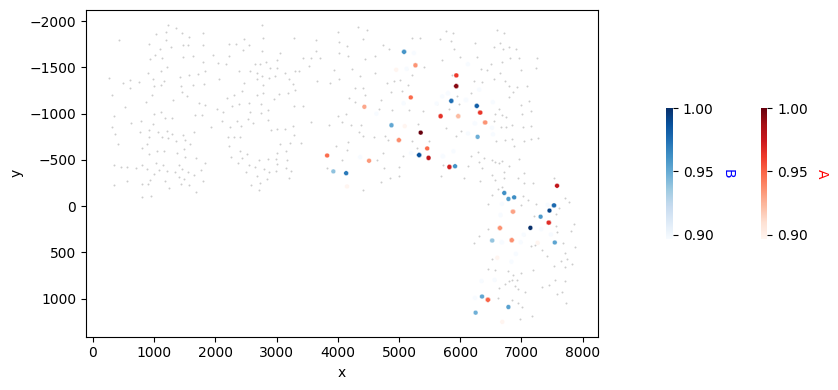

In [44]:
from matplotlib.colors import Normalize

lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == gpair,
            :
    ].copy()

fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=2, linewidth=0,alpha = 0.4)

lig_gene_vec = np.array(adata_plot.to_df().loc[lr_pairs_ct.cell1, 'Lamc3'].values)
rec_gene_vec = np.array(adata_plot.to_df().loc[lr_pairs_ct.cell2, 'Itgav'].values)

lr_pairs_ct['A'] = lig_gene_vec
lr_pairs_ct['B'] = rec_gene_vec
lr_pairs_ct_nz = lr_pairs_ct.loc[lr_pairs_ct[['A','B']].sum(1) > 0].copy()
global_min = min(lig_gene_vec.min(), rec_gene_vec.min())
global_max = min(lig_gene_vec.max(), rec_gene_vec.max())

sns.scatterplot(x='x', y='y',
    palette='Reds',s=12, data=loc_df.loc[lr_pairs_ct_nz.cell1,:],
    hue = lr_pairs_ct_nz['A'].values,
    #edgecolor='black',
    alpha=1.0,
    ax= ax
)
norm = Normalize(1, global_max)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.get_legend().remove()
cax = ax.figure.colorbar(sm,ax=ax,shrink=0.4, pad=-0.01)
cax.outline.set_visible(False)
cax.set_label('A', color='red', rotation=270, labelpad=15)

sns.scatterplot(x='x', y='y',
    palette='Blues',s=12, data=loc_df.loc[lr_pairs_ct_nz.cell2,:],
    hue = lr_pairs_ct_nz['B'].values,
    #edgecolor='black',
    alpha=1.0,
    ax= ax
)
ax.get_legend().remove()
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm,ax=ax,shrink=0.4, pad=0.1)
cax.outline.set_visible(False)
cax.set_label('B', color='blue', rotation=270, labelpad=15)

# ax.axhline(-195,ls='--',c='r')
# ax.axhline(-240,ls='--',c='r')
# ax.axvline(75,ls='--',c='r')
# ax.axvline(115,ls='--',c='r')
# ax.set_xlim(75, 100)
# ax.set_ylim(-240, -195)
ax.invert_yaxis()
plt.tight_layout()

In [150]:
from matplotlib.colors import Normalize

def get_data(lig_rec_pair, gpair, cont_type='other'):
    if cont_type == 'other':
        o = np.array(other_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict[gpair][index][0]
        y = data_list_dict[gpair][index][1]
        us1 = umi_sums[gpair][gpair.split('=')[0]]
        us2 = umi_sums[gpair][gpair.split('=')[1]]
    else:
        o = np.array(close_contact_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict_close[gpair][index][0]
        y = data_list_dict_close[gpair][index][1]
        us1 = umi_sums_close[gpair][gpair.split('=')[0]]
        us2 = umi_sums_close[gpair][gpair.split('=')[1]]
    return (x, y, us1, us2)

def plot_norm_lr_boundary_in_same_plot2(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1,
    gene2,
    count_df,
    merged_res,
    shrink_fraction=1.0,
    file_name = None,
    figsize = (7,5),
    markersize = 10,
    cont_type = 'other',
    copula_params=model2.CopulaParams()
):
    int_type = gpair
    lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == int_type,
            :
    ].copy()

    tmp = loc_df
    tmp = tmp.loc[
        list(set(lr_pairs_ct.cell1).union(lr_pairs_ct.cell2).intersection(tmp.index)),
        :
    ]

    x, y, us1, us2 = get_data(lr_index, gpair, cont_type=cont_type)
    copula_params = copula_params._replace(return_sum=False)
    sx = np.log(x.sum() / us1.sum())
    sy = np.log(y.sum() / us2.sum())
    res = merged_res[gpair].copy()
    coeff = res.loc[lr_index].copula_coeff
    loglikvec = model2.calculate_mahalanobis_distance(
        [coeff, sx, sy],
        x,
        y,
        us1,
        us2,
        copula_params
    )
    lr_pairs_ct['copula_score'] = loglikvec
    
    selected_cells_1 = list(set(lr_pairs_ct.cell1).intersection(set(tmp.index)))
    selected_cells_2 = list(set(lr_pairs_ct.cell2).intersection(set(tmp.index)))

    max_gene1 = count_df.loc[selected_cells_1, gene1].values.max()
    max_gene2 = count_df.loc[selected_cells_2, gene2].values.max()
    global_max = max(max_gene1, max_gene2)
    global_min = min(
        count_df.loc[selected_cells_1, gene1].values.min(),
        count_df.loc[selected_cells_2, gene2].values.min()
    )
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
    colors = np.array(count_df.loc[selected_cells_1, gene1].values)
    tmp = loc_df.loc[selected_cells_1,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',
                     palette='Reds',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=-0.05)
    cax.outline.set_visible(False)
    cax.set_label(gene1, color='red', rotation=270, labelpad=15)

    if isinstance(gene2,list):
        colors = np.array(count_df.loc[selected_cells_2, gene2].sum(1).values)
    else:
        colors = np.array(count_df.loc[selected_cells_2, gene2].values)
    tmp = loc_df.loc[selected_cells_2,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',
                    #marker="^",
                     palette='Blues',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.set_title(f"{lr_index} - copula: {coeff:.2f} \n {gpair}")
    #ax.set_title(gene1 + " | " + gene2 + "\n" + gpair)
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction, pad=-0.05)
    cax.outline.set_visible(False)
    if isinstance(gene2,list):
        cax.set_label('+'.join(gene2), color='blue', rotation=270, labelpad=15)
    else:
        cax.set_label(gene2, color='blue', rotation=270, labelpad=15)


    # draw edges
    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score, 0.95))
    cmap = plt.get_cmap('Greys')
    lr_pairs_ct = lr_pairs_ct.loc[lr_pairs_ct.copula_score >= 0.5]
    for ind,row in lr_pairs_ct.iterrows():
        x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
        x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
        dx = x2 - x1
        dy = y2 - y1
        color = cmap(norm(row.copula_score))
        # ax.plot([x1, x2], [y1, y2], color='black',
        #         linestyle='-', markersize=0.5,linewidth=0.3)
        ax.quiver(np.array([x1]), np.array([y1]), 
                  np.array([dx]), np.array([dy]),
                  angles='xy', scale_units='xy',
                  color=color,
                  scale=1, 
                  headwidth=5,
                  headaxislength=2.5,
                  headlength=5,
                  width=0.002,
                 )
        # ax.arrow(x1, y1, dx, dy, head_width=0.05, 
        #          head_length=0.1, fc='k', ec='k')

    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score,0.95))
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=0)
    cax.outline.set_visible(False)
    cax.set_label('mhl', color='blue', rotation=270, labelpad=15)
    
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    plt.show()

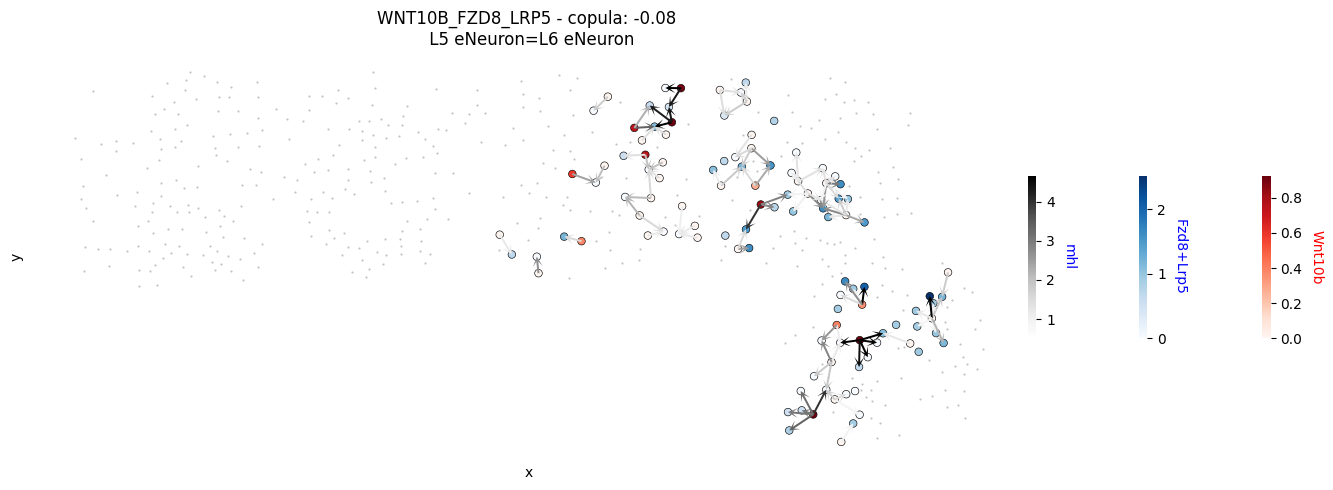

In [154]:
gpair = 'L5 eNeuron=L6 eNeuron'
lr_index = 'WNT10B_FZD8_LRP5'
plot_norm_lr_boundary_in_same_plot2(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Wnt10b',
    gene2=['Fzd8', 'Lrp5'],
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5),
    file_name='seqfish_{}_two_color.pdf'.format(lr_index)
)

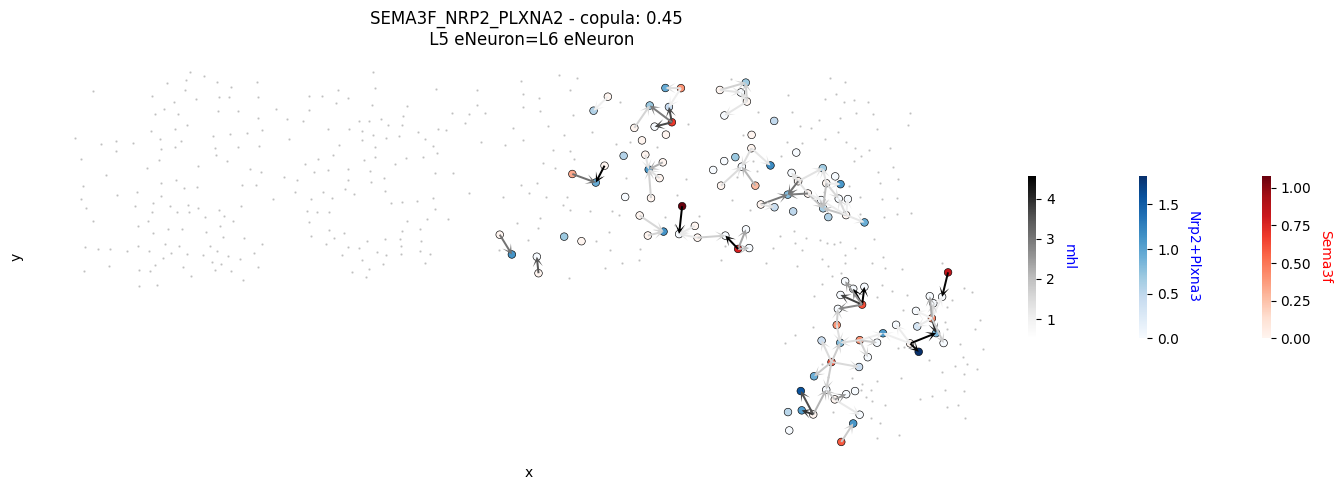

In [153]:
gpair = 'L5 eNeuron=L6 eNeuron'
lr_index = 'SEMA3F_NRP2_PLXNA2'
plot_norm_lr_boundary_in_same_plot2(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Sema3f',
    gene2=['Nrp2', 'Plxna3'],
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5),
    file_name='seqfish_{}_two_color.pdf'.format(lr_index)
)

In [128]:
from matplotlib.colors import Normalize
def plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1,
    gene2,
    count_df,
    merged_res,
    shrink_fraction=1.0,
    file_name = None,
    figure_parent = ".",
    figsize = (7,5),
    markersize = 10,
    cont_type = 'other',
    copula_params=model2.CopulaParams()
):
    int_type = gpair
    lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == int_type,
            :
    ].copy()

    islist = False
    if isinstance(gene2,list):
        islist = True

    tmp = loc_df
    tmp = tmp.loc[
        list(set(lr_pairs_ct.cell1).union(lr_pairs_ct.cell2).intersection(tmp.index)),
        :
    ]

    x, y, us1, us2 = get_data(lr_index, gpair, cont_type=cont_type)
    copula_params = copula_params._replace(return_sum=False)
    sx = np.log(x.sum() / us1.sum())
    sy = np.log(y.sum() / us2.sum())

    if isinstance(merged_res, pd.DataFrame):
        res = merged_res.copy()
    else:
        res = merged_res[gpair].copy()
    
    coeff = res.loc[lr_index].copula_coeff
    loglikvec = model2.calculate_mahalanobis_distance(
        [coeff, sx, sy],
        x,
        y,
        us1,
        us2,
        copula_params
    )
    lr_pairs_ct['copula_score'] = loglikvec
    lr_pairs_ct[gene1] = count_df.loc[lr_pairs_ct.cell1, gene1].values
    if islist:
        lr_pairs_ct['+'.join(gene2)] = count_df.loc[lr_pairs_ct.cell2, gene2].sum(1).values
    else:
        lr_pairs_ct[gene2] = count_df.loc[lr_pairs_ct.cell2, gene2].values
    
    selected_cells_1 = list(set(lr_pairs_ct.cell1).intersection(set(tmp.index)))
    selected_cells_2 = list(set(lr_pairs_ct.cell2).intersection(set(tmp.index)))

    max_gene1 = count_df.loc[selected_cells_1, gene1].values.max()
    max_gene2 = count_df.loc[selected_cells_2, gene2].values.max()
    global_max = max(max_gene1, max_gene2)
    global_min = min(
        count_df.loc[selected_cells_1, gene1].values.min(),
        count_df.loc[selected_cells_2, gene2].values.min()
    )
    
    fig, ax = plt.subplots(1, 1, figsize=figsize,dpi=500)
    
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.1,alpha = 0.4)
    colors = np.array(count_df.loc[selected_cells_1, gene1].values)
    tmp = loc_df.loc[selected_cells_1,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',
                    palette='Reds',s=markersize, data=tmp,
                    #edgecolor='black',
                    alpha=1.0,
                    ax= ax)
    # sns.scatterplot(x='x', y='y', hue='gene',
    #                          palette='Reds',s=15, 
    #                     data=tmp,alpha=0.7,ax= ax[i])
    #norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    # norm = Normalize(
    #     vmin=tmp['gene'].min(), 
    #     vmax=np.quantile(tmp['gene'].values,0.6)
    # )
    norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=-0.01)
    cax.outline.set_visible(False)
    cax.set_label(gene1, color='red', rotation=270, labelpad=15)

    if islist:
        colors = np.array(count_df.loc[selected_cells_2, gene2].sum(1).values)
    else:
        colors = np.array(count_df.loc[selected_cells_2, gene2].values)
    tmp = loc_df.loc[selected_cells_2,:].copy()
    tmp.loc[:, 'gene'] = colors
    # sns.scatterplot(x='x', y='y', hue='gene',marker="^",
    #                  palette='Blues',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    sns.scatterplot(x='x', y='y', hue='gene',
                    palette='Blues',s=markersize, data=tmp,
                    #edgecolor='black',
                    alpha=1.0,
                    ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    # norm = Normalize(
    #     vmin=tmp['gene'].min(), 
    #     vmax=np.quantile(tmp['gene'].values,0.6)
    # )
    norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.set_title(f"{lr_index} - copula: {coeff:.2f} \n {gpair}")
    #ax.set_title(gene1 + " | " + gene2 + "\n" + gpair)
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction, pad=-0.01)
    cax.outline.set_visible(False)
    cax.set_label(gene2, color='blue', rotation=270, labelpad=15)


    # draw edges
    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score, 0.9))
    cmap = plt.get_cmap('Greys')
    lr_pairs_ct = lr_pairs_ct.loc[lr_pairs_ct.copula_score >= 0.5]
    if islist:
        lr_pairs_ct_nz = lr_pairs_ct.loc[lr_pairs_ct[[gene1, '+'.join(gene2)]].sum(1) > 0].copy()
    else:
        lr_pairs_ct_nz = lr_pairs_ct.loc[lr_pairs_ct[[gene1, gene2]].sum(1) > 0].copy()
    for ind,row in lr_pairs_ct_nz.iterrows():
        x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
        x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
        dx = x2 - x1
        dy = y2 - y1
        color = cmap(norm(row.copula_score))
        # ax.plot([x1, x2], [y1, y2], color='black',
        #         linestyle='-', markersize=0.5,linewidth=0.3)
        ax.quiver(np.array([x1]), np.array([y1]), 
                  np.array([dx]), np.array([dy]),
                  angles='xy', scale_units='xy',
                  color=color,
                  scale=1, 
                  headwidth=5,
                  headaxislength=2.5,
                  headlength=5,
                  width=0.002,
                 )
        # ax.arrow(x1, y1, dx, dy, head_width=0.05, 
        #          head_length=0.1, fc='k', ec='k')
    # for ind,row in loglik_df_filt.iterrows():
    #     color = cmap(norm(row.copula_score))
    #     x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
    #     x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
    #     ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
    #             linestyle='-', markersize=0.5,linewidth=1)

    # norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
    #                  vmax=np.quantile(lr_pairs_ct.copula_score,0.9))
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=0)
    cax.outline.set_visible(False)
    cax.set_label('mhl', color='blue', rotation=270, labelpad=15)
    
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    plt.show()
    return lr_pairs_ct_nz 

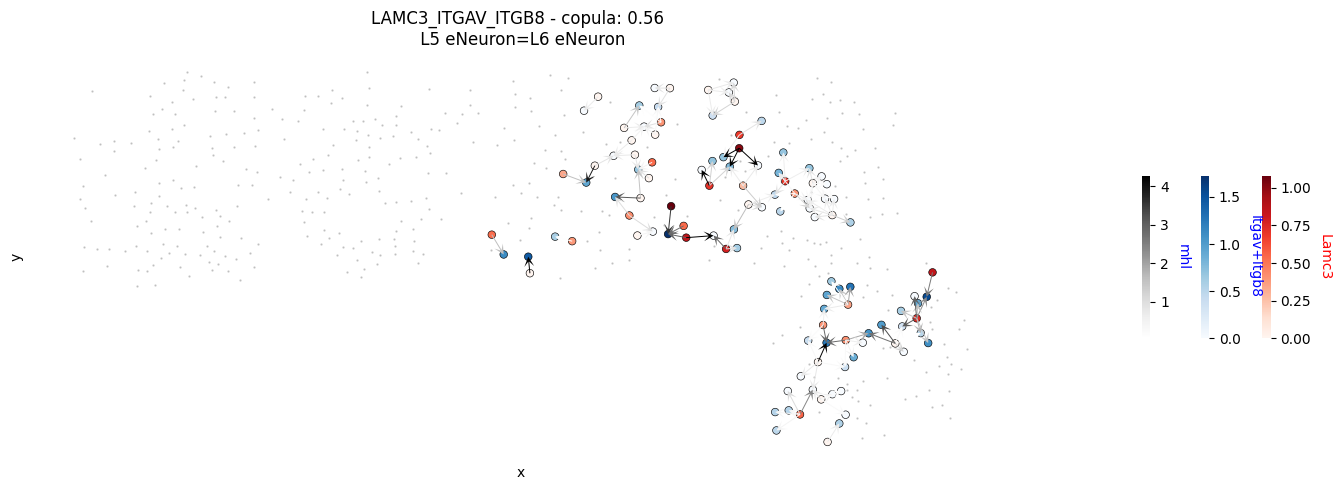

In [127]:
gpair = 'L5 eNeuron=L6 eNeuron'
lr_index = 'LAMC3_ITGAV_ITGB8'
plot_norm_lr_boundary_in_same_plot2(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Lamc3',
    gene2=['Itgav', 'Itgb8'],
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

In [62]:
count_df.sum(1).median()

5425.0

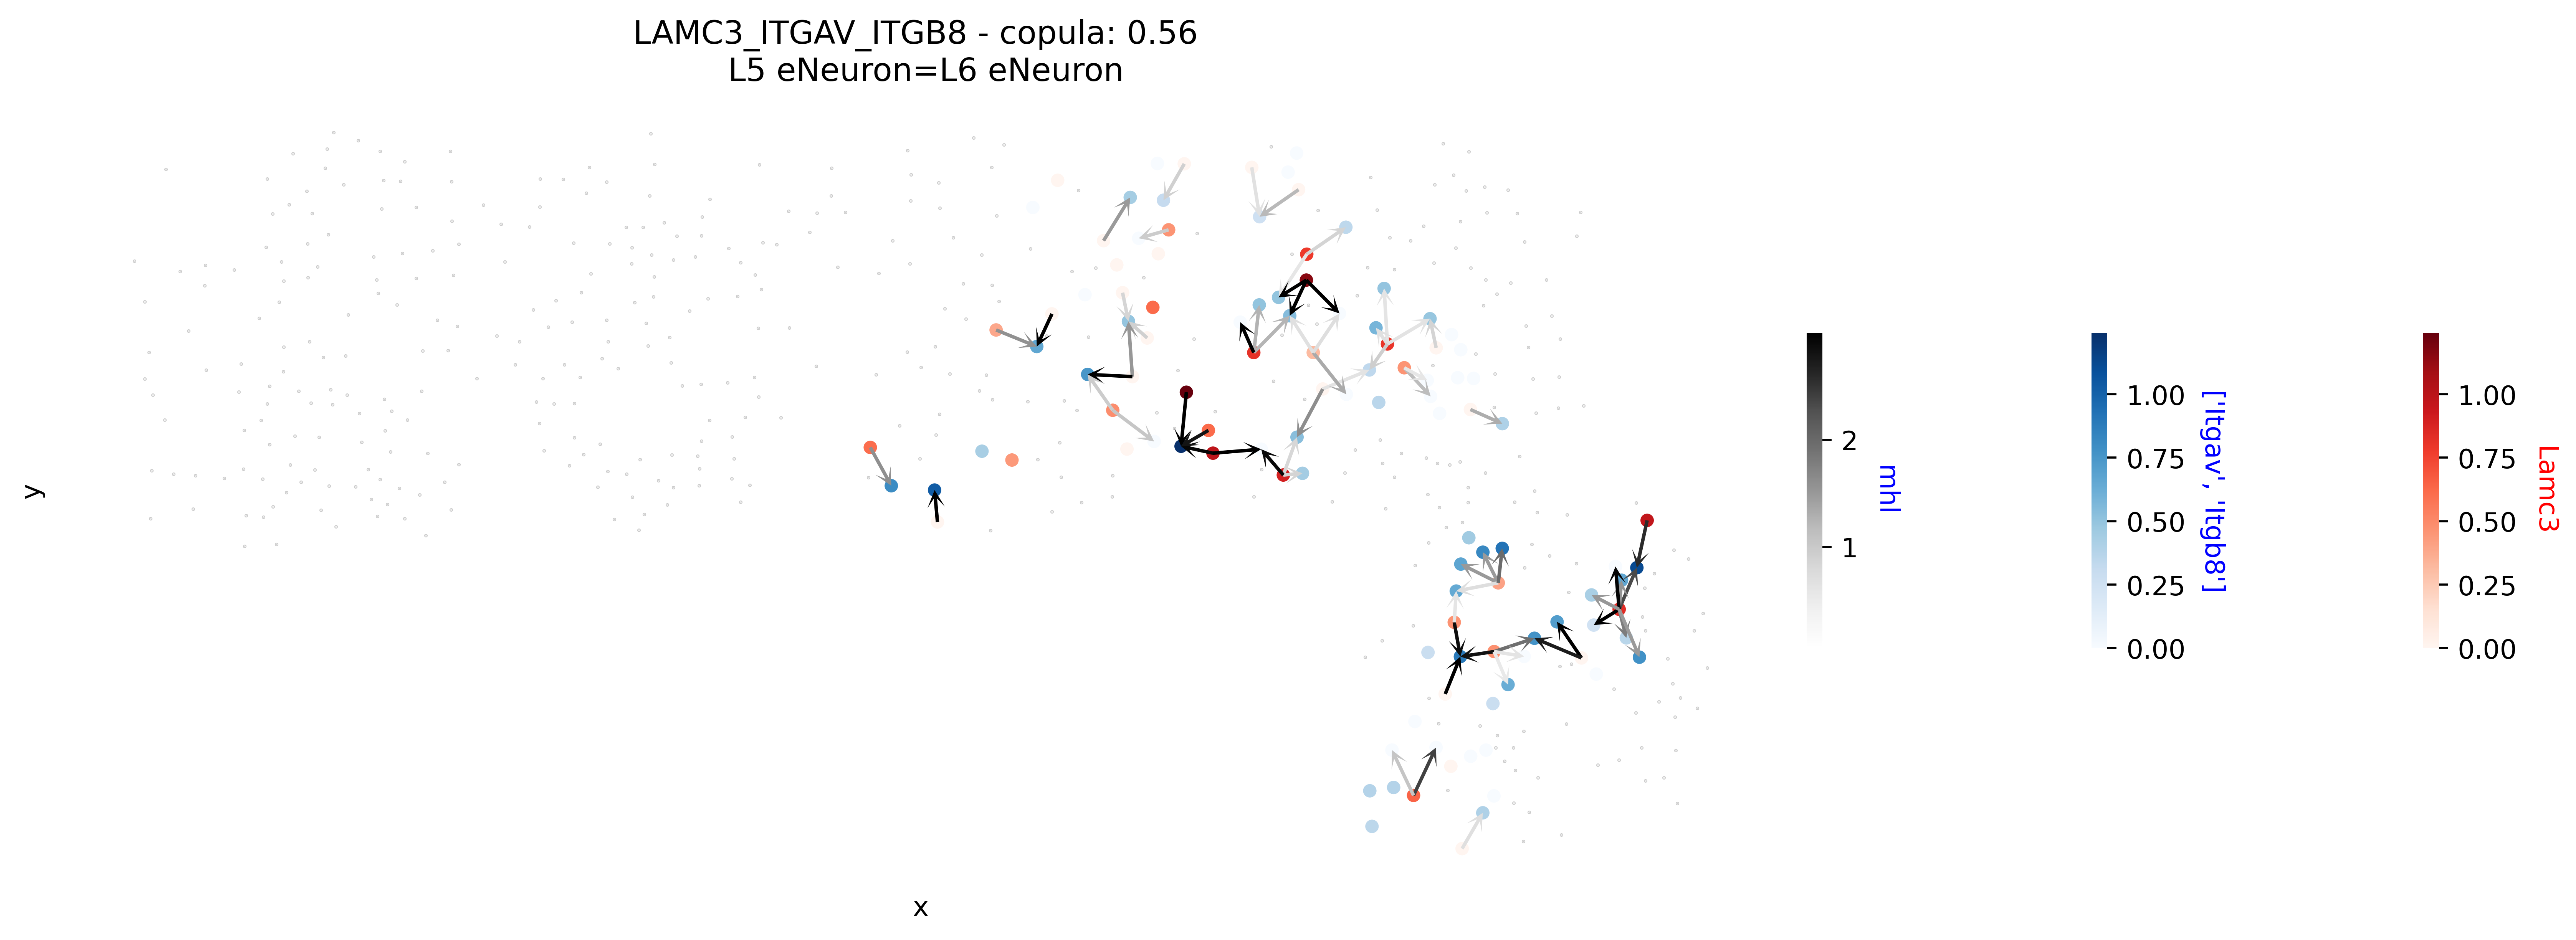

In [121]:
gpair = 'L5 eNeuron=L6 eNeuron'
lr_index = 'LAMC3_ITGAV_ITGB8'
lig_ct = plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Lamc3',
    gene2=['Itgav', 'Itgb8'],
    count_df = adata_plot.to_df(),
    merged_res=merged_res_dict,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
    file_name='seqfish_{}_two_color.pdf'.format(lr_index)
)